# Name(s)
**PUT YOUR FULL NAME(S) HERE**

## Should we grade this notebook? (Answer yes or no)

???YES OR NO???

**Instructions:** Pair programming assignment. Submit only a single notebook unless you deviate significantly after lab on Thursday. If you submit individually, make sure you indicate who you worked with originally. Make sure to include your first and last names. For those students who push to individual repos but still work in groups, please indicate which notebook should be graded.

# Ensemble Learning and Perceptron

## Lab Assignment

This is a pair programming assignment. I strongly
discourage individual work for this (and other team/pair programming) lab(s), even if you think you can do it
all by yourself. Also, this is a pair programming assignment, not a ”work in teams of two” assignment. Pair
programming requires joint work on all aspects of the project without delegating portions of the work to individual
1
team members. For this lab, I want all your work — discussion, software development, analysis of the results,
report writing — to be products of joint work.
Students enrolled in the class can pair with other students enrolled in the class. Students on the waitlist can
pair with other students on the waitlists. In the cases of ”odd person out” situations, a team of three people can
be formed, but that team must (a) ask and answer one additional question, and (b) work as a pair would, without
delegation of any work off-line.

## At the end of this lab, I should be able to
* Formulate your own questions and understand how you can go about getting answers
* Understand how to select an algorithm for your task
* Implement ensemble methods gradient boosting and random forest

## Our data
We will be using a well known housing dataset from Boston.
<pre>
 Variables in order:
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
</pre>

In [1]:
import pandas as pd
df = pd.read_csv("housing/boston_fixed.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


**Exercise 1.** Read the descriptions of the questions above, and come up with three reasonable questions with corresponding methods to test them. The only one that you cannot write, is the one we will do as a class, which I use as an example here:

Example questions: 
* What are factors that are most predictive of the median value of owner-occupied homes? 
* Is there a small subset of the total number of variables that could be used in predictive model and not sacrifice model accuracy?
* Can we say that any of these factors are causing the median home values to go up? 

Methodology:
1. Empirically determine the best modeling method from our known list of ensemble learners and decision trees.
2. Using this best model, compute a feature importance score
3. Graph the feature importance score and see if this is a dip. Use this as a cutoff if so, if not, then select the best N features and verify model performance does not change significantly.
4. NO!!! We cannot say anything about causation with our machine learning models. There are a lot of good discussions out there on why we can't say much about casuation. [See this one for example](https://towardsdatascience.com/causality-in-machine-learning-101-for-dummies-like-me-f7f161e7383e). BUT we can say a bit about correlation and what features are impacting our overall model.

**YOUR SOLUTION HERE**

**For the next few questions, we will lean heavily upon sklearn and the built-in models. We'll implement our own methods later in the lab, but this is better to provide a consistent experience.**

**Exercises 2-9**
What are the factors that are most predictive of the median value of owner-occupied homes? Use the following methodology:

1. Empirically determine the best modeling method from our known list of ensemble learners and decision trees (see code for more details)
2. Using this best model, compute a feature importance score and rank the features by this

### Code to get you started
I included all of the imports I used in this section right here. I encourage you to take a look at their documentation. I also encourage you to try and mess with the parameters yourself and see if you can come up with better combinations. Finally, you can completely break the overall flow of what I've laid out as long as you accomplish the main goals.

In [29]:
%%capture 
!pip install scikit-posthocs

In [52]:
# this is for plotting
%matplotlib inline 

import copy

# our standard imports
import numpy as np
import pandas as pd

# of course we need to be able to split into training and test
from sklearn.model_selection import train_test_split

# we need a "loss" function
from sklearn.metrics import mean_squared_error, r2_score

# This is where we can get our models
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# This is what I used for comparing my models
import scipy.stats as stats
import scikit_posthocs as sp

X = df.drop("MEDV",axis=1)
y = df["MEDV"]

# Below are sample arguments, manually modify some of them and see what happens (we'll do this another time with grid search)
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gb_1 = ensemble.GradientBoostingRegressor(**params)
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gb_2 = ensemble.GradientBoostingRegressor(**params)
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
rf_1 = RandomForestRegressor(n_estimators=100)
rf_2 = RandomForestRegressor(n_estimators=500)

models = [('Gradient Boosting 1',gb_1),('Gradient Boosting 2',gb_2),
          ('DTree 1',regr_1),('DTree 2',regr_2),
          ('RF 1',rf_1),('RF 2',rf_2)
         ]

**Exercise 2** Fill in the following code that finds the mean squared error for 30 repeated hold-out cross-validation experiments for each classifier. In other words, fill in my code and produce something similar to my output. It is very important to realize that you will get different numbers since this is stochastic.

In [30]:
num_iterations = 30
predictions = []
ytests = []
for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    models_train = copy.deepcopy(models)
    # YOUR SOLUTION HERE
        
errors = {}
for desc,model in models_train:
    errors[desc] = []
    for iteration in range(num_iterations):
        # YOUR SOLUTION HERE
errors = pd.DataFrame(errors)

In [33]:
errors.head()

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
0,9.539921,6.906843,22.108259,20.163991,12.560732,9.286971
1,17.460781,17.382044,32.871397,23.408169,17.453864,17.025082
2,13.346346,7.687953,15.683847,13.615807,7.130643,6.705585
3,9.168756,4.883167,36.156508,10.932996,5.660529,5.717660
4,15.510768,7.505495,41.957346,14.025336,9.948209,9.562223


In [31]:
errors.describe()

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,11.883399,9.683125,28.917211,20.642717,10.633576,10.517292
std,4.924642,5.944130,10.997239,10.880040,5.534104,5.556213
min,4.579167,3.749431,14.227647,7.681839,4.529371,4.220657
25%,8.627451,5.951857,22.167827,13.632976,6.277539,6.031955
50%,10.590273,8.607003,26.272067,18.203397,9.907739,9.590604
75%,14.994481,11.317597,33.300747,25.177372,12.655157,13.549623
max,23.340855,33.778558,54.051859,53.940791,30.866791,28.893415


**Exercise 3** Perform a one-way ANOVA to determine if there are any significant differences between methods

F_onewayResult(statistic=30.14747889664212, pvalue=5.345091071433792e-22)

**Exercise 4** Perform a post-hoc pairwise test with bonferroni multiple test correction

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
Gradient Boosting 1,-1.000000e+00,1.000000e+00,2.480826e-09,0.002574,1.000000e+00,1.000000e+00
Gradient Boosting 2,1.000000e+00,-1.000000e+00,1.772836e-10,0.000149,1.000000e+00,1.000000e+00
DTree 1,2.480826e-09,1.772836e-10,-1.000000e+00,0.072676,5.472130e-10,4.598960e-10
DTree 2,2.574422e-03,1.489747e-04,7.267579e-02,-1.000000,5.139194e-04,4.340323e-04
RF 1,1.000000e+00,1.000000e+00,5.472130e-10,0.000514,-1.000000e+00,1.000000e+00
RF 2,1.000000e+00,1.000000e+00,4.598960e-10,0.000434,1.000000e+00,-1.000000e+00


**Exercise 5** Which method(s) perform the best? Consider which methods you can actually say with certainty perform better than the rest.

**Exercise 6** Spoiler... There should be more a few models that we are unable to distinguish using 30 trials. Rerun your above analysis, but this time repeat it with 200 trials instead of 30. Is there now a clear winner? This can definitely take a while...

In [47]:
num_iterations = 200
predictions = []
ytests = []
for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    models_train = copy.deepcopy(models)
    # YOUR SOLUTION HERE
        
errors = {}
for desc,model in models_train:
    errors[desc] = []
    for iteration in range(num_iterations):
        # YOUR SOLUTION HERE
errors = pd.DataFrame(errors)

,Gradient Boosting 1,Gradient Boosting 2,DTree 1,DTree 2,RF 1,RF 2
Gradient Boosting 1,-1.000000e+00,1.621325e-12,2.585626e-66,1.283942e-11,4.071984e-06,6.911974e-07
Gradient Boosting 2,1.621325e-12,-1.000000e+00,2.784387e-90,1.507581e-28,2.014063e-01,4.353873e-01
DTree 1,2.585626e-66,2.784387e-90,-1.000000e+00,1.579233e-21,6.475009e-83,3.935068e-84
DTree 2,1.283942e-11,1.507581e-28,1.579233e-21,-1.000000e+00,9.256417e-23,1.456094e-23
RF 1,4.071984e-06,2.014063e-01,6.475009e-83,9.256417e-23,-1.000000e+00,1.000000e+00
RF 2,6.911974e-07,4.353873e-01,3.935068e-84,1.456094e-23,1.000000e+00,-1.000000e+00


RF 2                    3.679515
RF 1                    3.834495
Gradient Boosting 2     3.852611
Gradient Boosting 1     4.936870
DTree 2                 5.920786
DTree 1                10.859334
dtype: float64

**Exercise 6** Are there still any ties? If so, what are the best models? From there select the top model in terms of average error. Would this have been your same conclusion with only 30 experiments?

**Exercise 7** With you model of choice, calculate the mean_squared_error and r2_score.

Mean squared error: 4.61
Test Variance score: 0.92


**Exercise 8** Now compute feature importance using the method we've developed in previous labs. I have two loops here. One is that I rerun train_test_split 50 times as you can see from above this makes a difference. Then I also permute each feature 100 times. Test your code with much smaller numbers.

In [65]:
num_iterations = 10
percent_diff_score = {}
iterations = {}
experiments = {}
for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    # YOUR SOLUTION HERE
    


ZN          0.001522
CHAS        0.002573
RAD         0.018705
INDUS       0.054856
B           0.105710
PTRATIO     0.133865
AGE         0.184651
CRIM        0.294451
NOX         0.364589
TAX         0.839877
RM          5.929645
DIS        10.735753
LSTAT      12.388118
Name: mean, dtype: float64

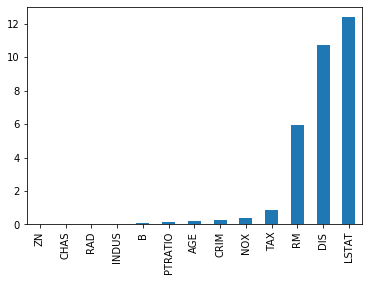

In [69]:
# NOTE: I did (new_score-orig_score)/orig_score, so the most important feature is the one with the largest average difference
percent_diff_score_data=pd.DataFrame(percent_diff_score).describe().loc['mean'].sort_values()
display(percent_diff_score_data)
percent_diff_score_data.plot.bar()

Based on the analysis when this notebook was last run, I would say that the three most important features are RM, DIS, and LSTAT. Let's see what happens when we compare our performance.

In [73]:
num_iterations = 30
predictions = []
ytests = []
for iteration in range(num_iterations):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.10,shuffle=True)
    # YOUR SOLUTION HERE

In [74]:
errors = {}
for desc in ['All features','Subset']:
    errors[desc] = []
    for iteration in range(num_iterations):
        # YOUR SOLUTION HERE
errors = pd.DataFrame(errors)
errors.describe()

,All features,Subset
count,30.000000,30.000000
mean,11.005750,16.605776
std,5.250063,6.520309
min,4.463181,8.218935
25%,6.557377,11.134245
50%,8.732062,14.414473
75%,15.408115,22.826222
max,21.485179,29.822662


I would say that is not too bad of a difference in score considering we are only using 3 of the features.

**Exercise 9** Now what if I told you that Random Forest and other classifiers have built-in measures for feature importance. Run the following code and compare the feature importance scores. The calculation of these needs to be saved for another time and place, but the trees themselves contain information about feature importance based on the location in the tree a feature is most often selected.

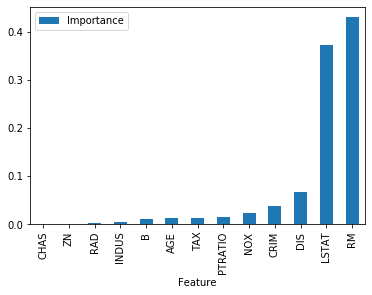

In [75]:
forest = RandomForestRegressor(n_estimators=500)
forest.fit(X,y)
importances = forest.feature_importances_
importances = pd.DataFrame({'Feature':X.columns,'Importance':importances})
importances.sort_values(by='Importance').set_index('Feature').plot.bar()

**Implementation from scratch portion**: We are now going to implement two ensemble learning methods from scratch and see how our implementations compare to sklearn.

**Exercise 10** Implement a simple random forest classifier and compare the performance to one of the random forest classifiers above.

In [90]:
errors = {}
for desc in ['sklearn RF','Our RF']:
    errors[desc] = []
    for iteration in range(num_iterations):
        # YOUR SOLUTION HERE
errors = pd.DataFrame(errors)
errors.describe()

,sklearn RF,Our RF
count,10.000000,10.000000
mean,12.737828,17.057502
std,3.329105,9.236010
min,7.159545,9.181140
25%,10.697455,11.162742
50%,12.498135,14.804409
75%,14.601846,16.960383
max,17.954829,40.438191


**Exercise 10** Implement gradient boosting from scratch using a mean squared error loss function. Compare the performance. I "boosted" 100 times. I've shown my validation graph. Every run is a little different, and it would definitely make this algorithm smarter if you stopped based on the validation graph.

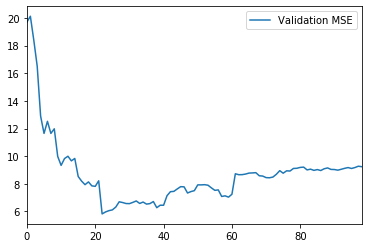

In [155]:
pd.DataFrame({"Validation MSE":val_mses}).plot.line()

In [156]:
errors = {}
for desc in ['sklearn GB','Our Gradient Boosting']:
    errors[desc] = []
    for iteration in range(num_iterations):
        # YOUR SOLUTION HERE
errors = pd.DataFrame(errors)
errors.describe()

,sklearn GB,Our Gradient Boosting
count,10.000000,10.000000
mean,8.301988,15.298447
std,2.913444,10.377214
min,4.871719,8.623325
25%,6.359372,10.719235
50%,7.804318,12.606270
75%,9.495140,13.775581
max,15.031566,44.240582
